# 5G MLB QUBO Solver

In this notebook we present a tutorial for solving 5G Network Mobility Load Balancing(MLB) problem on the Digital Annealer Emulator which is run on a CPU. More information on the functionalities of the Digital Annealer Development Kit (DADK) can be found in Development_KIT_Documentation. This tutorial will help the user to get insights in developing the QUBO for a NP-Hard optimization problem, and the solution strategy using the Digital Annealer.

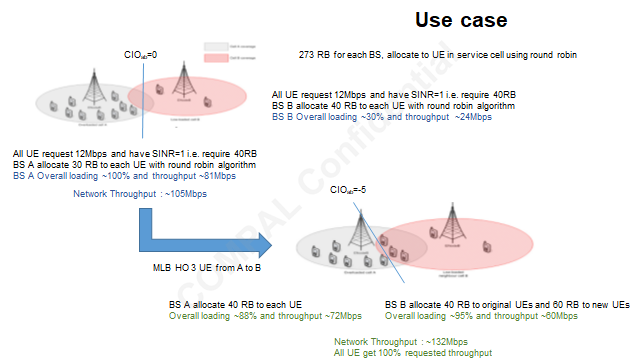

## Problem Specification
The MLB problem is to optimizes the load distribution of base satations via tuning a parameter named cell individual offset
(CIO) to control the user handovers. There are many research solving this problem such as https://arxiv.org/pdf/1906.00767.pdf.
Here we try to solve this problem using QUBO formulation to find optimal CIO which can improve overll network throughput.

## Problem Formulation

Let,
\begin{equation*}
\begin{split}
B &= \text{Total number of Base Stations}, \\
U &= \text{Total number of User Equipments}, \\
\end{split}
\end{equation*}

The decision variable is $x_{bu} = \{0,1\}$, such that $\forall b, u$
\begin{equation*}
x_{bu} = \begin{cases}
1 &\text{if UE $u$ is camping on Base Station $b$}\;,\\
0 & \text{otherwise} \;.
\end{cases}
\end{equation*}

### **Constraints**
- 1. Maximum number of serviced UE for each Base Station is 128 

$$
\sum\limits_{u=1}^{U} x_{bu} \leq 128 \hspace{5em} \forall b
$$

- 2. Each UE must only camp on one Base Station
$$
(\sum\limits_{b=1}^{B} x_{bu} - 1) ^2 = 0 \hspace{5em} \forall u
$$


- 3. A3 event to trigger handover from its serving BS b' to a neighboring BS b 
$$
$$
  When handover occurred it must meet A3 event condiction
$$
(RSRP_{ub} - RSRP_{ub'} - 10)x_{ub} - CIO_{b'b} + 20 \geq 0 \hspace{5em} \forall u, b
$$
  When any A3 event condiction meet, UE should not stay in current service cell b' 
$$
(RSRP_{ub} - RSRP_{ub'} + 10)x_{ub'} < CIO_{b'b}  \hspace{5em} \forall u, b
$$



## Preparation
In this chapter we have prepared an environment for this tutorial. First we include some libraries for a digital annealer emulation, binary polynomial algebra and some analytical tools in python.

In [1]:
from dadk.QUBOSolverCPU import *
from dadk.BinPol import *

import numpy as np

### The MLB class
The class  `mlb` is initialized with given file which define a 5G netwrok parameters. The method`display` prints the 5G network configurations of BS/UE assignment. `createQubo` creates an energy function. `findSolution` does the complete annealing and prints detailed results.

In [2]:
class mlb:
    def __init__(self, file_name="./small_sample.txt"):
        f = open(file_name, "r")
        data = f.readlines()
        num_ue, num_bs = data[0].split()
        self.num_ue = int(num_ue)
        self.num_bs = int(num_bs)
        self.rsrp = np.zeros([self.num_ue, self.num_bs])
        self.capacity = np.zeros([self.num_ue, self.num_bs])
        self.prb = np.zeros([self.num_ue, self.num_bs])
        for n in range(1, self.num_ue * self.num_bs + 1):
            i, j, r, c, p = data[n].split()
            self.rsrp[int(i), int(j)] = float(r)
            self.capacity[int(i), int(j)] = float(c)
            self.prb[int(i), int(j)] = int(p)
 
        # init service cell of UE to maximum sinr(capacity)
        self.serving_list = np.zeros([self.num_ue])
        for i in range(len(self.capacity)):
            index = np.where(self.capacity[i] == np.max(self.capacity[i]))[0]
            self.serving_list[i] = index
        #++++ create variable index
        # variable x[u,b], cio[b,b']+slack_cio_ineq1[u,b]+slack_cio_ineq2[u,b], w[u,b]+slack : u index of ue, b: index of bs, b': index of service bs 
        self.next_index = 0;
        #assign x variable index offset
        self.x_index= np.zeros([self.num_ue,self.num_bs])
        start_index=self.next_index  
        for u in range(self.num_ue):
            for b in range(self.num_bs):
                self.x_index[u,b]=start_index;
                start_index = start_index+1
        self.next_index=start_index        
        #fibonacci encode of cio range 0~20
        d = 20
        self.cio=[0,1]
        while d+2>self.cio[-1]:
            self.cio.append(self.cio[-2]+self.cio[-1])
        N = len(self.cio) - 4
        c = d +2 -self.cio[N+2]
        self.cio_len = N
        self.cio[N+1] = c
        #assign cio variable index offset
        start_index = self.next_index
        self.cio_index= np.zeros([self.num_bs,self.num_bs])
        for b in range(self.num_bs):
            for b_p in range(self.num_bs):
                self.cio_index[b_p,b]=start_index;
                start_index = start_index+self.cio_len
        self.next_index = start_index
        
        #fibonacci encode of cio inequlity1 (RSRP_ub-RSRP_ub'-10)x_ub > (cio_b'b+20) range 0~110
        d = 20  #!!!!debug set limit from 110 to 20
        self.slack_cio_ineq1=[0,1]
        while d+2>self.slack_cio_ineq1[-1]:
            self.slack_cio_ineq1.append(self.slack_cio_ineq1[-2]+self.slack_cio_ineq1[-1])
        N = len(self.slack_cio_ineq1) - 4
        c = d +2 -self.slack_cio_ineq1[N+2]
        self.slack_cio_ineq1_len = N
        self.slack_cio_ineq1[N+1] = c
        #assign cio inequlity1 variable index offset
        start_index = self.next_index
        self.slack_cio_ineq1_index = np.zeros([self.num_ue, self.num_bs])
        for u in range(self.num_ue):
            for b in range(self.num_bs):
                self.slack_cio_ineq1_index[u,b]=start_index;
                start_index = start_index+self.slack_cio_ineq1_len
        self.next_index = start_index
        
        #fibonacci encode of cio inequlity2 (RSRP_ub-RSRP_ub'+10)x_ub' < cio_b'b range 0~110
        d = 20  #!!!!debug set limit from 110 to 20
        self.slack_cio_ineq2=[0,1]
        while d+2>self.slack_cio_ineq2[-1]:
            self.slack_cio_ineq2.append(self.slack_cio_ineq2[-2]+self.slack_cio_ineq2[-1])
        N = len(self.slack_cio_ineq2) - 4
        c = d +2 -self.slack_cio_ineq2[N+2]
        self.slack_cio_ineq2_len = N
        self.slack_cio_ineq2[N+1] = c
        #assign cio inequlity2 variable index offset
        start_index = self.next_index
        self.slack_cio_ineq2_index = np.zeros([self.num_ue, self.num_bs])
        for u in range(self.num_ue):
            for b in range(self.num_bs):
                self.slack_cio_ineq2_index[u,b]=start_index;
                start_index = start_index+self.slack_cio_ineq2_len
        self.next_index = start_index
        
        #total number of variables
        self.size = self.next_index

        
        
    def cio_value(self, b_handover=0, b_service=0, var=None):
        if var is None:
            var=[True]*self.size

        cio_index = int(self.cio_index[b_service,b_handover])
        cio_fibonacci=var[cio_index:cio_index+self.cio_len]
        cio=0
        for i in range(self.cio_len):
            if var[cio_index+i] == True:
                cio += int(self.cio[i+2])
        return cio
    
    def cio_slack1_value(self, ue=0, bs=0, var=None):
        if var is None:
            var=[True]*self.size

        cio_slack1_index = int(self.slack_cio_ineq1_index[ue,bs])
        cio_slack1_fibonacci=var[cio_slack1_index:cio_slack1_index+self.slack_cio_ineq1_len]
        cio_slack1=0
        for i in range(self.slack_cio_ineq1_len):
            if var[cio_slack1_index+i] == True:
                cio_slack1 += int(self.slack_cio_ineq1[i+2])
        return cio_slack1

    def cio_slack2_value(self, ue=0, bs=0, var=None):
        if var is None:
            var=[True]*self.size

        cio_slack2_index = int(self.slack_cio_ineq2_index[ue,bs])
        cio_slack2_fibonacci=var[cio_slack2_index:cio_slack2_index+self.slack_cio_ineq2_len]
        cio_slack2=0
        for i in range(self.slack_cio_ineq2_len):
            if var[cio_slack2_index+i] == True:
                cio_slack2 += int(self.slack_cio_ineq2[i+2])
        return cio_slack2
    
    def check_constraint(self, solution=None):
        QUBOs=self.QUBOs
        
        if solution is None:
            solution=[True]*self.size
        
        if QUBOs["coefficient"][2] != 0:        
            #++++ check C2
            C2=0
            for u in range(self.num_ue):
                tmpC2=0
                for b in range(self.num_bs):
                    if solution[int(self.x_index[u,b])]==True:
                        tmpC2+=1
                tmpC2 = tmpC2-1
                C2+=tmpC2*tmpC2
            if C2 == 0:
                print("Constraint C2 pass")
            else :
                print("Constraint C2 fail", C2)
        
        if QUBOs["coefficient"][3] != 0:        
            #++++ check C3
            for u in range(self.num_ue):
                b_p = int(self.serving_list[u])
                for b in range(self.num_bs):
                    if b != b_p :
                        cio = self.cio_value(b_handover=b,b_service=b_p,var=solution)
                        delta_rsrp = self.rsrp[u,b] - self.rsrp[u, b_p]
                        print("delta RSRP:",delta_rsrp, "x_[",u,b,"]:",solution[int(self.x_index[u,b])], "cio_[",b_p,b,"]:",cio)
                        slack1 = self.cio_slack1_value(ue=u,bs=b,var=solution)
                        c31 = (delta_rsrp-10)*solution[int(self.x_index[u,b])]-cio+20
                        print("slack 1:",slack1, "[", c31, "]")
                        slack2 = self.cio_slack2_value(ue=u,bs=b,var=solution)
                        c32 = cio-((delta_rsrp+10)*solution[int(self.x_index[u,b_p])])
                        print("slack 2:",slack2, "[", c32, "]")
        
    def display(self,solution=None):
        QUBOs=self.QUBOs

        if solution is None:
            solution=[True]*self.size

        print("num of UE = ", self.num_ue, "num of BS = ", self.num_bs)

        if QUBOs["coefficient"][3] != 0:
            #++++ QUBO include CIO constraint 
            for b in range(self.num_bs):
                for b_p in range(self.num_bs):
                    if b_p != b:
                        print("CIO from ",b_p,"to",b,"is",self.cio_value(b_handover=b,b_service=b_p,var=solution))
                    else:
                        print("CIO stay at ",b_p,"is",self.cio_value(b_handover=b,b_service=b_p,var=solution))
        

    #++++ createQubo
    #        int  coefficient[]: coefficient of each constraint, coefficient[0] is coefficient of objective function
    #        bool bOneHot: encode x variables as one hot variable 
    #        bool bGuide: set initial value of x to servied BS and CIO to 10 
    def createQubo(self, coefficient=[0,0,0,0,0], bOneHot=False, bGuide=False):
        if bOneHot == True: 
            qubo_var_shape = VarShapeSet(BitArrayShape('x', (self.num_ue,self.num_bs), one_hot=OneHot.one_way), BitArrayShape('', (self.size-self.num_ue*self.num_bs,)))        
        else:
            qubo_var_shape = VarShapeSet(BitArrayShape('x', (self.num_ue,self.num_bs), ), BitArrayShape('', (self.size-self.num_ue*self.num_bs,)))        


        H = BinPol(qubo_var_shape)
        C2 = BinPol(qubo_var_shape)
        C3 = BinPol(qubo_var_shape)
        
        
        if coefficient[4]==0:
            #++++BS have unlimited PRB, each UE can get all requested RB and objective is finding solution with minimum RB 
            for u in range(self.num_ue):
                temp_tp = BinPol()
                for b in range(self.num_bs):
                    temp_tp.set_term((-coefficient[0]/self.prb[u, b]), (self.x_index[u,b],))
                H.add(temp_tp)
        else:
            print('Need to add PRB constraint')
            return None
        
        if coefficient[2]!=0:
            #++++ constraint 2 each UE connect to one BS 
            for u in range(self.num_ue):
                tmpC2=BinPol()
                for b in range(self.num_bs):
                    tmpC2.set_term(1, (self.x_index[u,b],))
                tmpC2 = tmpC2-1
                C2+=tmpC2.power2()
            H.add(C2.multiply_scalar(coefficient[2]))
            #---- constraint 2 each UE connect to one BS 
        else :
            C2 - None

        if coefficient[3]!=0:
            #++++ constraint CIO for A3 event
            #C31 : (RSRP_ub-RSRP_ub'-10)x_ub > (cio_b'b+20)
            #C32 : (RSRP_ub-RSRP_ub'+10)x_ub' < cio_b'b
            N_slack1 = self.slack_cio_ineq1_len
            N_slack2 = self.slack_cio_ineq2_len
            N_cio = self.cio_len
        
            for u in range(self.num_ue):
                b_p = int(self.serving_list[u])

                if bGuide == True:
                    guide_config = None
                    guide_config = GuidanceConfig(qubo_var_shape)
                    guide_config.set_bit(('x', u, b_p), True)

                for b in range(self.num_bs):
                    CIO=BinPol()
                    for i in range(N_cio):
                        CIO.set_term(self.cio[i+2],(self.cio_index[b_p,b]+i,))
               
                    delta_rsrp = self.rsrp[u,b] - self.rsrp[u, b_p]

                    if b != b_p :
                        # C31
                        C31=BinPol()
                        slack1=BinPol()
                        for i in range(N_slack1):
                            slack1.set_term(self.slack_cio_ineq1[i+2],(self.slack_cio_ineq1_index[u,b]+i,))
                        C31.set_term(delta_rsrp-10,(self.x_index[u,b],))
                        C31=C31-CIO+20-slack1
                        #print("C31_u,b,bp",u,b,b_p,C31)
                        C3 += (C31.power2())
                        # C32
                        C32=BinPol()
                        slack2=BinPol()
                        for i in range(N_slack2):
                            slack2.set_term(self.slack_cio_ineq2[i+2],(self.slack_cio_ineq2_index[u,b]+i,))
                        C32.set_term(delta_rsrp+10,(self.x_index[u,b_p],))
                        C32=C32-CIO+slack2
                        #!!!!debug turn off C32  
                        #print("C32_u,b,bp",u,b,b_p,C32)
                        C3 += (C32.power2())
                        if bGuide == True:
                            #++++ add guide config for default CIO value = 10
                            guide_config = None
                            guide_config = GuidanceConfig(qubo_var_shape)
                            guide_config.set_bit(('',self.cio_index[b_p,b]-14), False)
                            guide_config.set_bit(('',self.cio_index[b_p,b]+1-14), True)
                            guide_config.set_bit(('',self.cio_index[b_p,b]+2-14), True)
                            guide_config.set_bit(('',self.cio_index[b_p,b]+3-14), True)
                            guide_config.set_bit(('',self.cio_index[b_p,b]+4-14), False)
                            guide_config.set_bit(('',self.cio_index[b_p,b]+5-14), False)

                            guide_config.set_bit(('x', u, b), False)

            H.add(C3.multiply_scalar(coefficient[3]))
            #---- constraint CIO for A3 event
        else :
            C3 = None
   
        self.QUBOs = {"H": H,  "constraint2":C2, "constraint3":C3, "coefficient":coefficient}
        return self.QUBOs

    def findSolution(self,QUBOs=None, solver=None):
        if QUBOs==None:
            QUBOs=self.QUBOs
        if solver==None:
            self.solver = QUBOSolverCPU(
                number_iterations    = 8000,              # total number of itrations per run
                number_runs          = 256,                  # number of stochastically independant runs
                temperature_start    = 2000,               # start temperature for annealing as float value
                temperature_end      = 10,                 # end temperature for annealing as float value 
                temperature_mode     = 0,                         # 0: reduce temperature by factor (1-temperature_decay) every temperature_interval steps
                                                              # 1: reduce temperature by factor (1-temperature_decay*temperature) every temperature_interval steps
                                                              # 2: reduce temperature by factor (1-temperature_decay*temperature^2) every temperature_interval steps
                temperature_decay    = 0.01,             # see temperature_mode 0
                temperature_interval = 10,                # see temperature_mode 0
                offset_increase_rate = 2000,               # increase of dynamic offset when no bit selected, set to 0.0 to switch off dynamic offset
                graphics             = True,                # create data for graphics output
                bit_precision        = 16
            )
            solver=self.solver
        
        print(QUBOs["H"])
        print(QUBOs["H"].one_hot)
        #print(QUBOs["H"].N)
        #print(QUBOs["H"].degree)
        print(QUBOs["H"].as_qbsolv())
        
        solution_list = solver.minimize(QUBOs["H"])

        
        self.configuration = solution_list.get_minimum_energy_solution().configuration
        print(self.configuration)

        print("q = %10.6f" % QUBOs["H"].compute(self.configuration))
        constraint=0
        if QUBOs["coefficient"][2] != 0:
            c2= QUBOs["constraint2"].compute(self.configuration)
            constraint += c2
            print("constraint2 = %10.6f" % c2)
        if QUBOs["coefficient"][3] != 0:
            c3= QUBOs["constraint3"].compute(self.configuration)
            constraint += c3
            print("constraint3 = %10.6f" % c3)
       
        self.display(self.configuration)        
        self.check_constraint(self.configuration)        
        
        solution_list.print_stats()
        solution_list.print_graphs(center_in_steps=None, center_in_percent=None, center_in_minimum_energy=False, 
                          width_in_steps=None, width_in_percent=None)
        
        return(constraint)



Following experiments try to find optimal solution of test sample which have 2 BS and 7UE. <br>
Test sample file(ex. "small_sample.txt") format is described as <br>
7(total UE) 2(total BS) <br>
0(UE index) 0(BS index) -89(RSRP)    1.812246191300625 (Capacity)  6 (RB required) <br>
0 1                 -103  0.04491553101947576                  215 <br>
1 0                  -90    1.582682354911556                    7 <br>
1 1                  -99    0.137503523749935                   70 <br>
2 0                  -91    1.582682354911556                    7 <br>
2 1                  -97   0.2624647071408777                   37 <br>
3 0                  -95   0.8434438252036525                   12 <br>
3 1                  -95   0.7057190507735135                   14 <br>
4 0                  -98   0.3232993226938424                   30 <br>
4 1                  -99   0.2624647071408777                   37 <br>
5 0                 -112  0.01435529297707005                  670 <br>
5 1                 -101   0.2122447432603954                   46 <br>
6 0                 -117 0.004555003994398939                 2111 <br>
6 1                 -101   0.2122447432603954                   46 <br>

line 1 denote total UE and total BS number
And following tuples is (UE index, BS index, RSRP, Capacity, RB required)
For example line 2 of "small_sample.txt" is {0 0                  -89    1.812246191300625                    6} which means
Reference Symbol Received Power(RSRP) of UE "0" from BS "0" is "-89" dBm and if UE "0" camp on BS "0" it required "6" RB to fullfill 3 Mbps downlink demand. Capacity is bit rate of each RE(one RB include 156 RE)

# Experiment 1.
In this experiment we did not limit PRB of each BS which means UE can get all required RB as UE camping on any BS. We try to minimize total RB required which means UE prefer to camp on BS with best RSRP value. <p>
Test file: "small_sample.txt" <br>
Objective function:
$$
\sum\limits_{b=1}^{B} \sum\limits_{u=1}^{U} x_{bu} * 1/(RB_{bu}) \forall b,u
$$
Constraint:
   - 2. Each UE must only camp on one Base Station
$$
(\sum\limits_{b=1}^{B} x_{bu} - 1) ^2 = 0 \hspace{5em} \forall u
$$



2800 - 408.3333333333333 x_0 + 800 x_0 x_1 - 400.2325581395349 x_1 - 407.14285714285717 x_2 + 800 x_2 x_3 - 400.7142857142857 x_3 - 407.14285714285717 x_4 + 800 x_4 x_5 - 401.35135135135135 x_5 - 404.1666666666667 x_6 + 800 x_6 x_7 - 403.57142857142856 x_7 - 401.6666666666667 x_8 + 800 x_8 x_9 - 401.35135135135135 x_9 - 400.07462686567163 x_10 + 800 x_10 x_11 - 401.0869565217391 x_11 - 400.0236854571293 x_12 + 800 x_12 x_13 - 401.0869565217391 x_13
{'one_way': [], 'two_way': []}
c constant 2800
p qubo 0 14 14 7
0 0 -408
1 1 -400
2 2 -407
3 3 -400
4 4 -407
5 5 -401
6 6 -404
7 7 -403
8 8 -401
9 9 -401
10 10 -400
11 11 -401
12 12 -400
13 13 -401
0 1 800
2 3 800
4 5 800
6 7 800
8 9 800
10 11 800
12 13 800

Attention: Found 192 not used bits!
[WARNING] The bit ('', 0) is not used!
[WARNING] The bit ('', 1) is not used!
[WARNING] The bit ('', 2) is not used!
[WARNING] The bit ('', 3) is not used!
[WARNING] The bit ('', 4) is not used!
[WARNING] The bit ('', 5) is not used!
[WARNING] The bit 

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1]
q = -30.626294
constraint2 =   0.000000
num of UE =  7 num of BS =  2
Constraint C2 pass
Input parameters
  Total number of iterations per run________: 1000
  number_runs_______________________________: 32
  Number of replicas________________________: 26
  Temperature mode__________________________: 0
  Temperature mode text_____________________: EXPONENTIAL
  Start temperature_________________________: 2000.0
  Final temperature (mode 3)________________: 10.0
  Temperature decay (mode 0)________________: 0.01
  Temperature interval (mode 0)_____________: 10
  Dynamic energy offset_____________________: 2000.0
  Solution mode_____________________________: COMPLETE
  Optimization method_______________________: annealing
  Annealer version__________________________: 2
  Bit precision_____________________________: 16
  Processor_________________________________: CPU
  graphics.value____________________________: 1
  graphics.name__________________

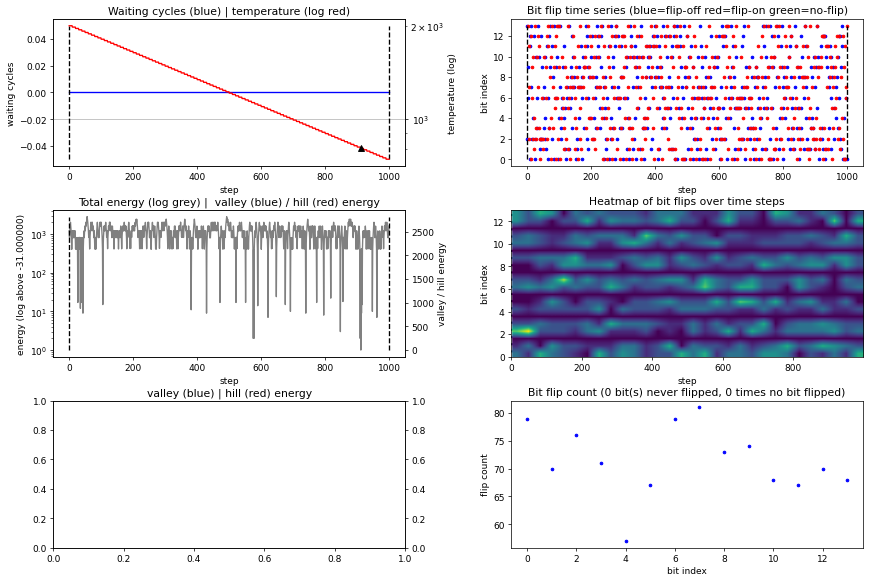

Find solution at 0 run


In [3]:
mlb_tc = mlb()

Q=mlb_tc.createQubo(coefficient=[50,0,400,0,0],bOneHot=False,bGuide=True)
DAU = QUBOSolverCPU(
            number_iterations    = 1000,              # total number of itrations per run
            number_runs          = 32,                  # number of stochastically independant runs
            temperature_start    = 2000,               # start temperature for annealing as float value
            temperature_end      = 10,                 # end temperature for annealing as float value 
            temperature_mode     = 0,                         # 0: reduce temperature by factor (1-temperature_decay) every temperature_interval steps
                                                              # 1: reduce temperature by factor (1-temperature_decay*temperature) every temperature_interval steps
                                                              # 2: reduce temperature by factor (1-temperature_decay*temperature^2) every temperature_interval steps
            temperature_decay    = 0.01,             # see temperature_mode 0
            temperature_interval = 10,                # see temperature_mode 0
            offset_increase_rate = 2000,               # increase of dynamic offset when no bit selected, set to 0.0 to switch off dynamic offset
            graphics             = True,                # create data for graphics output
            bit_precision        = 16
        )

if Q == None:
    print('Fail to create Qubo')
else:
    for i in range(5):
        if(mlb_tc.findSolution(QUBOs=Q,solver=DAU)==0):
            print("Find solution at", i, "run")
            break


# Experiment 2.
Following experiment 1 we add constraint 3 and increase solver search space by changing parameters "number_of_iterations" and "number_of_runs"


- 3. A3 event to trigger handover from its serving BS b' to a neighboring BS b 
$$
$$
  When handover occurred it must meet A3 event condiction
$$
(RSRP_{ub} - RSRP_{ub'} - 10)x_{ub} - CIO_{b'b} + 20 \geq 0 \hspace{5em} \forall u, b
$$
  When any A3 event condiction meet, UE should not stay in current service cell b' 
$$
(RSRP_{ub} - RSRP_{ub'} + 10)x_{ub'} < CIO_{b'b}  \hspace{5em} \forall u, b
$$


5600 - 392.3333333333333 x_0 + 800 x_0 x_1 + 8.0 x_0 x_26 + 16.0 x_0 x_27 + 24.0 x_0 x_28 + 40.0 x_0 x_29 + 64.0 x_0 x_30 + 8.0 x_0 x_31 - 8.0 x_0 x_128 - 16.0 x_0 x_129 - 24.0 x_0 x_130 - 40.0 x_0 x_131 - 64.0 x_0 x_132 - 8.0 x_0 x_133 - 784.2325581395348 x_1 + 48.0 x_1 x_26 + 96.0 x_1 x_27 + 144.0 x_1 x_28 + 240.0 x_1 x_29 + 384.0 x_1 x_30 + 48.0 x_1 x_31 + 48.0 x_1 x_44 + 96.0 x_1 x_45 + 144.0 x_1 x_46 + 240.0 x_1 x_47 + 384.0 x_1 x_48 + 48.0 x_1 x_49 - 406.14285714285717 x_2 + 800 x_2 x_3 - 2.0 x_2 x_26 - 4.0 x_2 x_27 - 6.0 x_2 x_28 - 10.0 x_2 x_29 - 16.0 x_2 x_30 - 2.0 x_2 x_31 + 2.0 x_2 x_140 + 4.0 x_2 x_141 + 6.0 x_2 x_142 + 10.0 x_2 x_143 + 16.0 x_2 x_144 + 2.0 x_2 x_145 - 799.7142857142858 x_3 + 38.0 x_3 x_26 + 76.0 x_3 x_27 + 114.0 x_3 x_28 + 190.0 x_3 x_29 + 304.0 x_3 x_30 + 38.0 x_3 x_31 + 38.0 x_3 x_56 + 76.0 x_3 x_57 + 114.0 x_3 x_58 + 190.0 x_3 x_59 + 304.0 x_3 x_60 + 38.0 x_3 x_61 - 391.14285714285717 x_4 + 800 x_4 x_5 - 8.0 x_4 x_26 - 16.0 x_4 x_27 - 24.0 x_4 x_28 - 40

[1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]
q = -29.626294
constraint2 =   0.000000
constraint3 =   1.000000
num of UE =  7 num of BS =  2
CIO stay at  0 is 13
CIO from  1 to 0 is 9
CIO from  0 to 1 is 10
CIO stay at  1 is 12
Constraint C2 pass
delta RSRP: -14.0 x_[ 0 1 ]: 0 cio_[ 0 1 ]: 10
slack 1: 10 [ 10.0 ]
slack 2: 15 [ 14.0 ]
delta RSRP: -9.0 x_[ 1 1 ]: 0 cio_[ 0 1 ]: 10
slack 1: 10 [ 10.0 ]
slack 2: 9 [ 9.0 ]
delta RSRP: -6.0 x_[ 2 

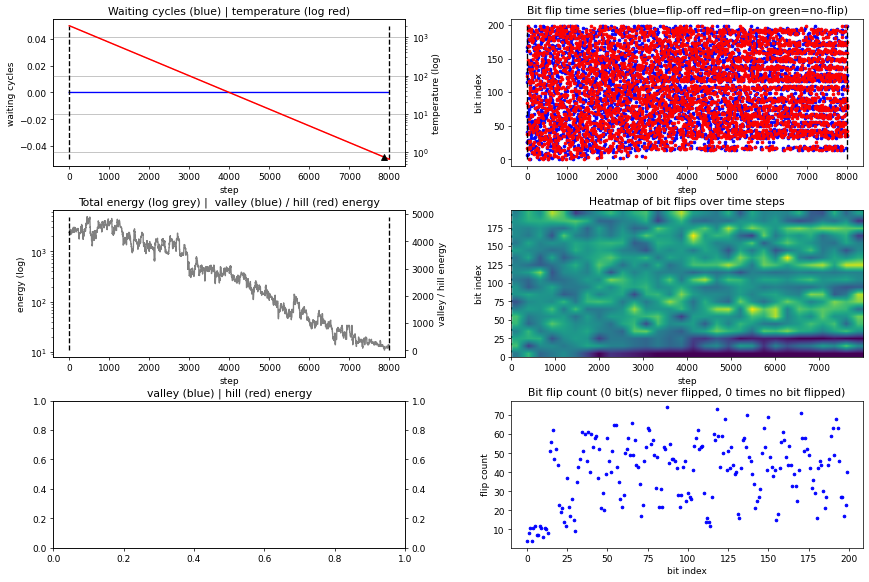

5600 - 392.3333333333333 x_0 + 800 x_0 x_1 + 8.0 x_0 x_26 + 16.0 x_0 x_27 + 24.0 x_0 x_28 + 40.0 x_0 x_29 + 64.0 x_0 x_30 + 8.0 x_0 x_31 - 8.0 x_0 x_128 - 16.0 x_0 x_129 - 24.0 x_0 x_130 - 40.0 x_0 x_131 - 64.0 x_0 x_132 - 8.0 x_0 x_133 - 784.2325581395348 x_1 + 48.0 x_1 x_26 + 96.0 x_1 x_27 + 144.0 x_1 x_28 + 240.0 x_1 x_29 + 384.0 x_1 x_30 + 48.0 x_1 x_31 + 48.0 x_1 x_44 + 96.0 x_1 x_45 + 144.0 x_1 x_46 + 240.0 x_1 x_47 + 384.0 x_1 x_48 + 48.0 x_1 x_49 - 406.14285714285717 x_2 + 800 x_2 x_3 - 2.0 x_2 x_26 - 4.0 x_2 x_27 - 6.0 x_2 x_28 - 10.0 x_2 x_29 - 16.0 x_2 x_30 - 2.0 x_2 x_31 + 2.0 x_2 x_140 + 4.0 x_2 x_141 + 6.0 x_2 x_142 + 10.0 x_2 x_143 + 16.0 x_2 x_144 + 2.0 x_2 x_145 - 799.7142857142858 x_3 + 38.0 x_3 x_26 + 76.0 x_3 x_27 + 114.0 x_3 x_28 + 190.0 x_3 x_29 + 304.0 x_3 x_30 + 38.0 x_3 x_31 + 38.0 x_3 x_56 + 76.0 x_3 x_57 + 114.0 x_3 x_58 + 190.0 x_3 x_59 + 304.0 x_3 x_60 + 38.0 x_3 x_61 - 391.14285714285717 x_4 + 800 x_4 x_5 - 8.0 x_4 x_26 - 16.0 x_4 x_27 - 24.0 x_4 x_28 - 40

[1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
q = -30.031056
constraint2 =   0.000000
constraint3 =   0.000000
num of UE =  7 num of BS =  2
CIO stay at  0 is 3
CIO from  1 to 0 is 12
CIO from  0 to 1 is 9
CIO stay at  1 is 2
Constraint C2 pass
delta RSRP: -14.0 x_[ 0 1 ]: 0 cio_[ 0 1 ]: 9
slack 1: 11 [ 11.0 ]
slack 2: 13 [ 13.0 ]
delta RSRP: -9.0 x_[ 1 1 ]: 0 cio_[ 0 1 ]: 9
slack 1: 11 [ 11.0 ]
slack 2: 8 [ 8.0 ]
delta RSRP: -6.0 x_[ 2 1 ]:

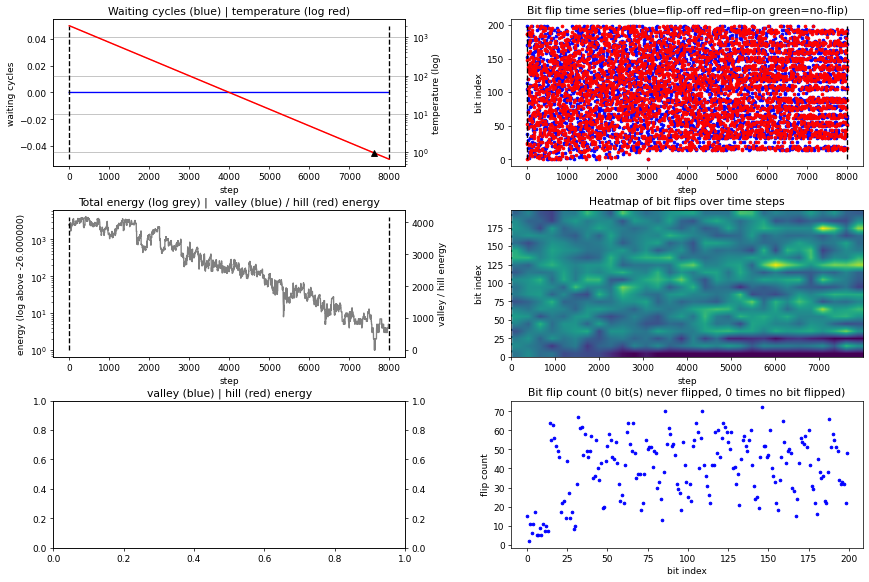

Find solution at 1 run


In [4]:
mlb_tc = mlb()

Q=mlb_tc.createQubo(coefficient=[50,0,400,1,0],bOneHot=False,bGuide=True)
DAU = QUBOSolverCPU(
            number_iterations    = 8000,              # total number of itrations per run
            number_runs          = 256,                  # number of stochastically independant runs
            temperature_start    = 2000,               # start temperature for annealing as float value
            temperature_end      = 10,                 # end temperature for annealing as float value 
            temperature_mode     = 0,                         # 0: reduce temperature by factor (1-temperature_decay) every temperature_interval steps
                                                              # 1: reduce temperature by factor (1-temperature_decay*temperature) every temperature_interval steps
                                                              # 2: reduce temperature by factor (1-temperature_decay*temperature^2) every temperature_interval steps
            temperature_decay    = 0.01,             # see temperature_mode 0
            temperature_interval = 10,                # see temperature_mode 0
            offset_increase_rate = 2000,               # increase of dynamic offset when no bit selected, set to 0.0 to switch off dynamic offset
            graphics             = True,                # create data for graphics output
            bit_precision        = 16
        )

if Q == None:
    print('Fail to create Qubo')
else:
    for i in range(5):
        if(mlb_tc.findSolution(QUBOs=Q,solver=DAU)==0):
            print("Find solution at", i, "run")
            break


# Experiment 3.
Following experiment 1 but we modify RB required at line 9 from "14" to "4" which means when UE3 camping on BS1 it require less PRB. <p>
Test file: "small_sample2.txt" <br>


2800 - 408.3333333333333 x_0 + 800 x_0 x_1 - 400.2325581395349 x_1 - 407.14285714285717 x_2 + 800 x_2 x_3 - 400.7142857142857 x_3 - 407.14285714285717 x_4 + 800 x_4 x_5 - 401.35135135135135 x_5 - 404.1666666666667 x_6 + 800 x_6 x_7 - 412.5 x_7 - 401.6666666666667 x_8 + 800 x_8 x_9 - 401.35135135135135 x_9 - 400.07462686567163 x_10 + 800 x_10 x_11 - 401.0869565217391 x_11 - 400.0236854571293 x_12 + 800 x_12 x_13 - 401.0869565217391 x_13
{'one_way': [], 'two_way': []}
c constant 2800
p qubo 0 14 14 7
0 0 -408
1 1 -400
2 2 -407
3 3 -400
4 4 -407
5 5 -401
6 6 -404
7 7 -412
8 8 -401
9 9 -401
10 10 -400
11 11 -401
12 12 -400
13 13 -401
0 1 800
2 3 800
4 5 800
6 7 800
8 9 800
10 11 800
12 13 800

Attention: Found 192 not used bits!
[WARNING] The bit ('', 0) is not used!
[WARNING] The bit ('', 1) is not used!
[WARNING] The bit ('', 2) is not used!
[WARNING] The bit ('', 3) is not used!
[WARNING] The bit ('', 4) is not used!
[WARNING] The bit ('', 5) is not used!
[WARNING] The bit ('', 6) is no

[1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1]
q = -38.959627
constraint2 =   0.000000
num of UE =  7 num of BS =  2
Constraint C2 pass
Input parameters
  Total number of iterations per run________: 1000
  number_runs_______________________________: 32
  Number of replicas________________________: 26
  Temperature mode__________________________: 0
  Temperature mode text_____________________: EXPONENTIAL
  Start temperature_________________________: 2000.0
  Final temperature (mode 3)________________: 10.0
  Temperature decay (mode 0)________________: 0.01
  Temperature interval (mode 0)_____________: 10
  Dynamic energy offset_____________________: 2000.0
  Solution mode_____________________________: COMPLETE
  Optimization method_______________________: annealing
  Annealer version__________________________: 2
  Bit precision_____________________________: 16
  Processor_________________________________: CPU
  graphics.value____________________________: 1
  graphics.name__________________

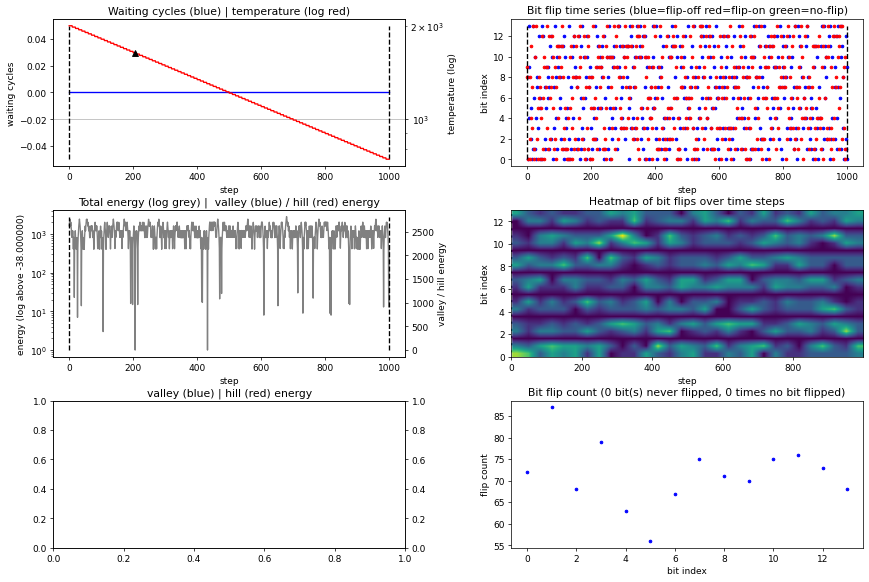

Find solution at 0 run


In [5]:
mlb_tc = mlb(file_name="small_sample2.txt")

Q=mlb_tc.createQubo(coefficient=[50,0,400,0,0],bOneHot=False,bGuide=True)
DAU = QUBOSolverCPU(
            number_iterations    = 1000,              # total number of itrations per run
            number_runs          = 32,                  # number of stochastically independant runs
            temperature_start    = 2000,               # start temperature for annealing as float value
            temperature_end      = 10,                 # end temperature for annealing as float value 
            temperature_mode     = 0,                         # 0: reduce temperature by factor (1-temperature_decay) every temperature_interval steps
                                                              # 1: reduce temperature by factor (1-temperature_decay*temperature) every temperature_interval steps
                                                              # 2: reduce temperature by factor (1-temperature_decay*temperature^2) every temperature_interval steps
            temperature_decay    = 0.01,             # see temperature_mode 0
            temperature_interval = 10,                # see temperature_mode 0
            offset_increase_rate = 2000,               # increase of dynamic offset when no bit selected, set to 0.0 to switch off dynamic offset
            graphics             = True,                # create data for graphics output
            bit_precision        = 16
        )

if Q == None:
    print('Fail to create Qubo')
else:
    for i in range(5):
        if(mlb_tc.findSolution(QUBOs=Q,solver=DAU)==0):
            print("Find solution at", i, "run")
            break


# Experiment 4.
Following experiment 2 but we modify RB required at line 9 from "14" to "4" which means when UE3 camping on BS1 it require less PRB. <p>
Test file: "small_sample2.txt" <br>


5600 - 392.3333333333333 x_0 + 800 x_0 x_1 + 8.0 x_0 x_26 + 16.0 x_0 x_27 + 24.0 x_0 x_28 + 40.0 x_0 x_29 + 64.0 x_0 x_30 + 8.0 x_0 x_31 - 8.0 x_0 x_128 - 16.0 x_0 x_129 - 24.0 x_0 x_130 - 40.0 x_0 x_131 - 64.0 x_0 x_132 - 8.0 x_0 x_133 - 784.2325581395348 x_1 + 48.0 x_1 x_26 + 96.0 x_1 x_27 + 144.0 x_1 x_28 + 240.0 x_1 x_29 + 384.0 x_1 x_30 + 48.0 x_1 x_31 + 48.0 x_1 x_44 + 96.0 x_1 x_45 + 144.0 x_1 x_46 + 240.0 x_1 x_47 + 384.0 x_1 x_48 + 48.0 x_1 x_49 - 406.14285714285717 x_2 + 800 x_2 x_3 - 2.0 x_2 x_26 - 4.0 x_2 x_27 - 6.0 x_2 x_28 - 10.0 x_2 x_29 - 16.0 x_2 x_30 - 2.0 x_2 x_31 + 2.0 x_2 x_140 + 4.0 x_2 x_141 + 6.0 x_2 x_142 + 10.0 x_2 x_143 + 16.0 x_2 x_144 + 2.0 x_2 x_145 - 799.7142857142858 x_3 + 38.0 x_3 x_26 + 76.0 x_3 x_27 + 114.0 x_3 x_28 + 190.0 x_3 x_29 + 304.0 x_3 x_30 + 38.0 x_3 x_31 + 38.0 x_3 x_56 + 76.0 x_3 x_57 + 114.0 x_3 x_58 + 190.0 x_3 x_59 + 304.0 x_3 x_60 + 38.0 x_3 x_61 - 391.14285714285717 x_4 + 800 x_4 x_5 - 8.0 x_4 x_26 - 16.0 x_4 x_27 - 24.0 x_4 x_28 - 40

[1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1]
q = -36.959627
constraint2 =   0.000000
constraint3 =   2.000000
num of UE =  7 num of BS =  2
CIO stay at  0 is 4
CIO from  1 to 0 is 5
CIO from  0 to 1 is 10
CIO stay at  1 is 13
Constraint C2 pass
delta RSRP: -14.0 x_[ 0 1 ]: 0 cio_[ 0 1 ]: 10
slack 1: 10 [ 10.0 ]
slack 2: 14 [ 14.0 ]
delta RSRP: -9.0 x_[ 1 1 ]: 0 cio_[ 0 1 ]: 10
slack 1: 10 [ 10.0 ]
slack 2: 10 [ 9.0 ]
delta RSRP: -6.0 x_[ 2 

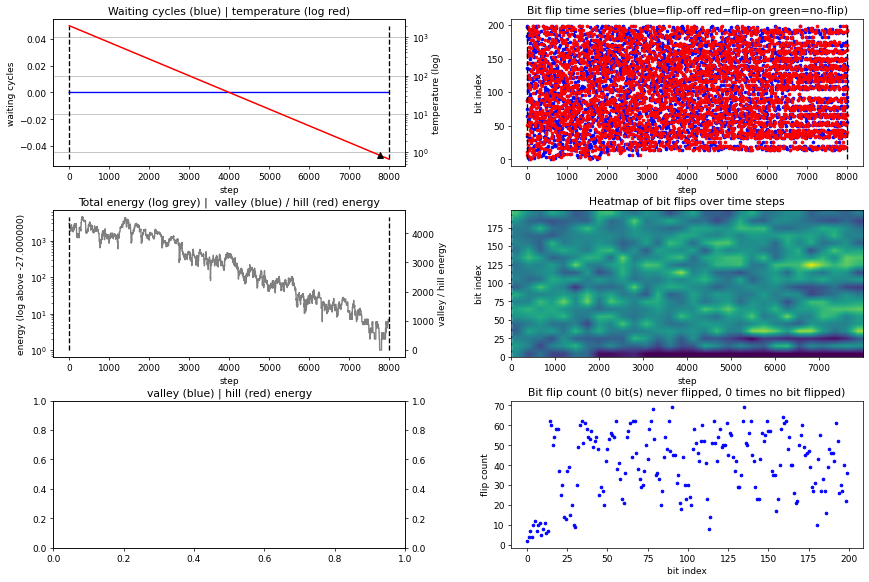

5600 - 392.3333333333333 x_0 + 800 x_0 x_1 + 8.0 x_0 x_26 + 16.0 x_0 x_27 + 24.0 x_0 x_28 + 40.0 x_0 x_29 + 64.0 x_0 x_30 + 8.0 x_0 x_31 - 8.0 x_0 x_128 - 16.0 x_0 x_129 - 24.0 x_0 x_130 - 40.0 x_0 x_131 - 64.0 x_0 x_132 - 8.0 x_0 x_133 - 784.2325581395348 x_1 + 48.0 x_1 x_26 + 96.0 x_1 x_27 + 144.0 x_1 x_28 + 240.0 x_1 x_29 + 384.0 x_1 x_30 + 48.0 x_1 x_31 + 48.0 x_1 x_44 + 96.0 x_1 x_45 + 144.0 x_1 x_46 + 240.0 x_1 x_47 + 384.0 x_1 x_48 + 48.0 x_1 x_49 - 406.14285714285717 x_2 + 800 x_2 x_3 - 2.0 x_2 x_26 - 4.0 x_2 x_27 - 6.0 x_2 x_28 - 10.0 x_2 x_29 - 16.0 x_2 x_30 - 2.0 x_2 x_31 + 2.0 x_2 x_140 + 4.0 x_2 x_141 + 6.0 x_2 x_142 + 10.0 x_2 x_143 + 16.0 x_2 x_144 + 2.0 x_2 x_145 - 799.7142857142858 x_3 + 38.0 x_3 x_26 + 76.0 x_3 x_27 + 114.0 x_3 x_28 + 190.0 x_3 x_29 + 304.0 x_3 x_30 + 38.0 x_3 x_31 + 38.0 x_3 x_56 + 76.0 x_3 x_57 + 114.0 x_3 x_58 + 190.0 x_3 x_59 + 304.0 x_3 x_60 + 38.0 x_3 x_61 - 391.14285714285717 x_4 + 800 x_4 x_5 - 8.0 x_4 x_26 - 16.0 x_4 x_27 - 24.0 x_4 x_28 - 40

[1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0]
q = -38.959627
constraint2 =   0.000000
constraint3 =   0.000000
num of UE =  7 num of BS =  2
CIO stay at  0 is 6
CIO from  1 to 0 is 11
CIO from  0 to 1 is 9
CIO stay at  1 is 14
Constraint C2 pass
delta RSRP: -14.0 x_[ 0 1 ]: 0 cio_[ 0 1 ]: 9
slack 1: 11 [ 11.0 ]
slack 2: 13 [ 13.0 ]
delta RSRP: -9.0 x_[ 1 1 ]: 0 cio_[ 0 1 ]: 9
slack 1: 11 [ 11.0 ]
slack 2: 8 [ 8.0 ]
delta RSRP: -6.0 x_[ 2 1 ]

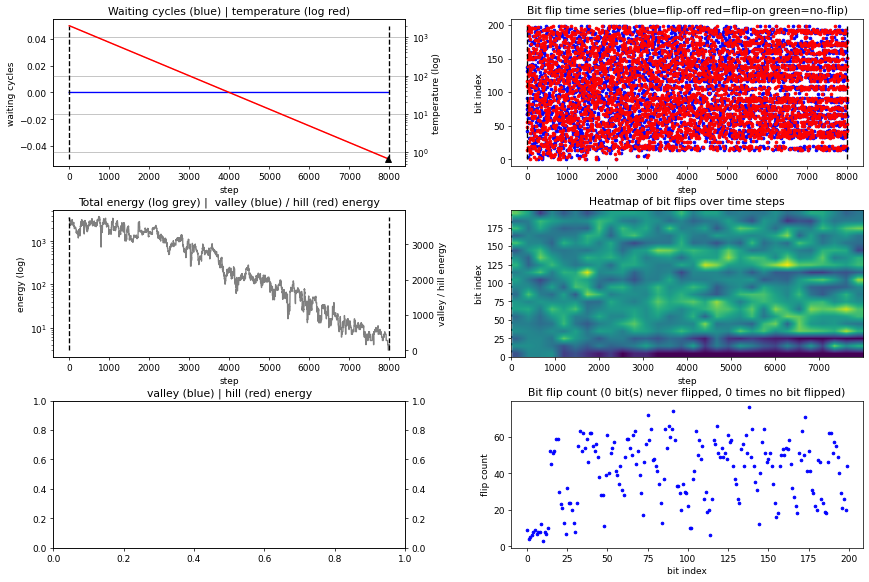

Find solution at 1 run


In [6]:
mlb_tc = mlb(file_name="small_sample2.txt")

Q=mlb_tc.createQubo(coefficient=[50,0,400,1,0],bOneHot=False,bGuide=True)
DAU = QUBOSolverCPU(
            number_iterations    = 8000,              # total number of itrations per run
            number_runs          = 256,                  # number of stochastically independant runs
            temperature_start    = 2000,               # start temperature for annealing as float value
            temperature_end      = 10,                 # end temperature for annealing as float value 
            temperature_mode     = 0,                         # 0: reduce temperature by factor (1-temperature_decay) every temperature_interval steps
                                                              # 1: reduce temperature by factor (1-temperature_decay*temperature) every temperature_interval steps
                                                              # 2: reduce temperature by factor (1-temperature_decay*temperature^2) every temperature_interval steps
            temperature_decay    = 0.01,             # see temperature_mode 0
            temperature_interval = 10,                # see temperature_mode 0
            offset_increase_rate = 2000,               # increase of dynamic offset when no bit selected, set to 0.0 to switch off dynamic offset
            graphics             = True,                # create data for graphics output
            bit_precision        = 16
        )

if Q == None:
    print('Fail to create Qubo')
else:
    for i in range(5):
        if(mlb_tc.findSolution(QUBOs=Q,solver=DAU)==0):
            print("Find solution at", i, "run")
            break
